In [4]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
import tensorflow_probability as tfp
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import tensorflow as tf
from scipy import stats
tfd=tfp.distributions
from tqdm import notebook
from scipy import optimize
from functools import partial
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")
tf.keras.backend.set_floatx('float64')

In [5]:
%matplotlib inline

### Read Data

In [6]:
energydt=np.load('energydt.npy')
x=energydt[:,:-1]
y=energydt[:,-1]

train=energydt[:865]
test=energydt[865:]

train_x=train[:,:-1]
train_y=train[:,-1].reshape(-1,1)

test_x=test[:,:-1]
test_y=test[:,-1].reshape(-1,1)

ntrain=len(train_x)
ntest=len(test_x)

#### normalization function

In [7]:
##define a normalization function
def norm_data(train, test,norm=True):
    std_train=np.ones(train.shape[1])
    mu_train=np.zeros(train.shape[1])
    if(norm):
        std_train = np.std(train, 0)
        mu_train=np.mean(train,0)

    train=(train - np.full(train.shape, mu_train)) / \
            np.full(train.shape, std_train)
    test=(test - np.full(test.shape, mu_train)) / \
            np.full(test.shape, std_train)
    return train,test,mu_train,std_train

### Ensemble method based of hetero regression(EN), for small dt do not use decay as shown in 2 cells below

In [8]:
class EN:
    def __init__(self,tau):
        self.tau=tau
    
    def model_musd(self,trainx,trainy,testx):
        #the model
        model=tf.keras.Sequential([
            tf.keras.layers.Dense(100,activation=tf.nn.elu),
            tf.keras.layers.BatchNormalization(axis=-1),
            tf.keras.layers.Dense(80,activation=tf.nn.elu),
            tf.keras.layers.BatchNormalization(axis=-1),
            tf.keras.layers.Dense(1+1),
            tfp.layers.DistributionLambda(
            lambda t:tfd.Normal(loc=t[...,:1],
            scale=tf.math.softplus(self.tau*t[...,1:])+0.001)),
        ])

        #the loss
        negloglik = lambda y, p_y: -p_y.log_prob(y)

        #the model fitting for 5 models
        mut=np.zeros(len(testx))
        sdt=np.zeros(len(testx))
        
       
        STEPS_PER_EPOCH=np.ceil(len(trainx)/128)

        #learning rate    
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
          0.001,
          decay_steps=STEPS_PER_EPOCH*100,
          decay_rate=1,
          staircase=False)

        def get_optimizer():
            return tf.keras.optimizers.Adam(lr_schedule)

        for i in notebook.tnrange(5):
            model.compile(optimizer=get_optimizer(),loss=negloglik)
            model.fit(trainx,trainy,epochs=300,batch_size=128,verbose=0)
            yhatt=model(testx)
            mu1=np.array(yhatt.mean()).ravel()
            sd1=np.array(yhatt.stddev()).ravel()
            mut=np.c_[mut,mu1]
            sdt=np.c_[sdt,sd1]

        sdt=sdt[:,1:]
        mut=mut[:,1:]


        #the averaged mean and sd for the ensemble model
        muhat=np.mean(mut,1)
        sighat=np.sqrt(np.mean(sdt**2+mut**2,1)-muhat**2)
        return muhat, sighat


In [9]:
# #for small dt train without decay
# class EN:
#     def __init__(self,tau):
#         self.tau=tau
    
#     def model_musd(self,trainx,trainy,testx):
#         #the model
#         model=tf.keras.Sequential([
#             tf.keras.layers.Dense(100,activation=tf.nn.elu),
#             tf.keras.layers.BatchNormalization(axis=-1),
#             tf.keras.layers.Dense(50,activation=tf.nn.elu),
#             tf.keras.layers.BatchNormalization(axis=-1),
#             tf.keras.layers.Dense(1+1),
#             tfp.layers.DistributionLambda(
#             lambda t:tfd.Normal(loc=t[...,:1],
#             scale=tf.math.softplus(self.tau*t[...,1:])+0.001)),
#         ])

#         #the loss
#         negloglik = lambda y, p_y: -p_y.log_prob(y)

#         #the model fitting for 5 models
#         mut=np.empty(len(testx))
#         sdt=np.empty(len(testx))
#         for i in notebook.tnrange(5):
#             model.compile(optimizer=tf.optimizers.Adam(1e-3),loss=negloglik)
#             model.fit(trainx,trainy,epochs=500,batch_size=64,verbose=0)
#             yhatt=model(testx)
#             mu1=np.array(yhatt.mean()).ravel()
#             sd1=np.array(yhatt.stddev()).ravel()
#             mut=np.c_[mut,mu1]
#             sdt=np.c_[sdt,sd1]

#         sdt=sdt[:,1:]
#         mut=mut[:,1:]


#         #the averaged mean and sd for the ensemble model
#         muhat=np.mean(mut,1)
#         sighat=np.sqrt(np.mean(sdt**2+mut**2,1)-muhat**2)
#         return muhat, sighat



#### 2-fold cross validation for parameter tuning

In [6]:
tauval=[0.01,0.05,0.1]

In [7]:
## create 5 folds
id = np.arange(len(train_x))
kf = KFold(n_splits=2)
tuneresult=[]


for i in range(3):
    
    ## tuning parameter
    tautmp=tauval[i]

    for trainid, testid in kf.split(id):
        entmp=EN(tautmp)
        mutmp,stdtmp=entmp.model_musd(train_x[trainid],train_y[trainid],train_x[testid])

        
        ## extract validation y
        testytmp=train_y[testid]
 
        ##likelihood
        low=np.quantile(testytmp,0.05)
        high=np.quantile(testytmp,0.95)
        itv=np.linspace(low,high,9)
        itv=np.append(-np.infty,itv)
        itv=np.append(itv,np.infty)
        #outcome1 belongs to which interval
        ids=np.zeros(len(testytmp))
        for i in range(10):
            ids=ids+1*(testytmp.ravel()>itv[i+1])
        ids=ids.astype('int')
        
        l=(itv[ids]-mutmp)/stdtmp
        r=(itv[ids+1]-mutmp)/stdtmp
        prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
        ll_est=np.log(prtmp+1.e-10)
        
        tuneresult.append(ll_est.mean())            



In [8]:
list(zip([np.mean(tuneresult[i*2:(i+1)*2]) for i in range(3)],tauval))

[(-1.9617950288845325, 0.01),
 (-2.9865059110966974, 0.05),
 (-2.9926416701007583, 0.1)]

### Ten replications to evaluate the hard metrics

In [9]:
##function to create replication
def rep_iter(x,y,frac=0.4):
    n=len(x)
    ntest=int(np.floor(frac*n))
    allidx=np.random.permutation(n)
    trainidx= allidx[ntest:]
    testidx= allidx[:ntest]
    return x[trainidx],y[trainidx],x[testidx],y[testidx]
    

In [10]:
#initialize the metric
enll=[]
encal=[]
encalshp=[] #empirical coverage
enwidth=[] #empirical width
en90=[] #90 interval coverage
enmae=[]

In [11]:
np.random.seed(2021)
for a in range(10):
    train_x,train_y,test_x,test_y=rep_iter(x,y)
    ntrain=len(train_x)
    ntest=len(test_x)
    
    ntrain=len(train_x)
    ntest=len(test_x)

    
    ENmodel=EN(0.05)
    mutmp,stdtmp=ENmodel.model_musd(train_x,train_y,np.r_[train_x,test_x])
    enmu,enstd=mutmp[ntrain:],stdtmp[ntrain:]
    
    #####calculate metrics##############

    per=np.linspace(0.02,0.98,8) #quantile to study calibration
    pershp=np.linspace(0.4,0.999,20) #nominal quantile to study sharpness

    enc=[]
    for i in per:
        lquantile=(stats.norm.ppf(0.5-i/2.)*enstd+enmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*enstd+enmu)
        enc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

    encal.append(enc)
    
    
    enc1=[]    
    enwid=[]
    for i in pershp:
        lquantile=(stats.norm.ppf(0.5-i/2.)*enstd+enmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*enstd+enmu)
        enc1.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))
        enwid.append(np.median(rquantile-lquantile))
        
        
    encalshp.append(np.array(enc1))    
    enwidth.append(np.array(enwid))
    
    
    #ninty
    l90=(stats.norm.ppf(0.5-0.9/2.)*enstd+enmu)
    r90=(stats.norm.ppf(0.5+0.9/2.)*enstd+enmu)
    en90.append(np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel())))
    
    #log likelihood
    low=np.quantile(test_y,0.05)
    high=np.quantile(test_y,0.95)
    itv=np.linspace(low,high,9)
    itv=np.append(-np.infty,itv)
    itv=np.append(itv,np.infty)
    #outcome1 belongs to which interval
    id=np.zeros(len(test_y))
    for i in range(10):
        id=id+1*(test_y.ravel()>itv[i+1])
    id=id.astype('int')

    l=(itv[id]-enmu)/enstd
    r=(itv[id+1]-enmu)/enstd
    prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
    ll_est=np.log(prtmp+1e-10)
    enll.append(ll_est.mean())
    
    #mae
    enmae.append(np.abs(enmu-test_y.ravel()).mean()) #against the ground truth
    


In [12]:
def musd(x):
    print(np.mean(x),np.std(x))

musd(enll)
musd(en90)
musd(enmae)


-2.104764245660504 0.07627711823924246
0.779513888888889 0.019687836808798397
0.5672535164708422 0.013713421840110871


In [13]:
#calibration
def calcompu(x):
    x=np.array(x)
    n=len(x)
    cal=np.mean(x,0)
    calest=np.abs(x-per).mean(1)
    
    print(np.mean(calest),np.std(calest))
    
    return  cal

encalplot=calcompu(encal)

0.06581770833333336 0.014138359987583534


In [20]:
encalplot

array([0.01805556, 0.13489583, 0.25538194, 0.36666667, 0.48472222,
       0.60329861, 0.72083333, 0.8921875 ])

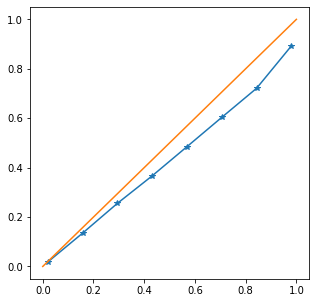

In [21]:
## calibration plot
plt.figure(figsize=(5,5))
plt.plot(per,encalplot,'-*')

plt.plot([0,1],[0,1])

In [22]:
def shpplt(cal,width): #median interval width calculation
    n=len(cal)
    cal=np.array(cal)
    width=np.array(width)
    low=np.max(cal[:,0])
    up=np.min(cal[:,-1])
    rangeint=np.linspace(low,up,30)
    widest=[]
    for i in range(n):
        widest.append(interp1d(cal[i],width[i])(rangeint))
    
    return rangeint,np.array(widest).mean(0)

    

In [23]:
enempcal,enempwid=shpplt(encalshp,enwidth)

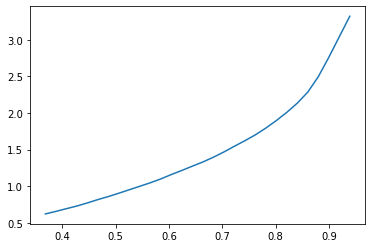

In [24]:
plt.plot(enempcal,enempwid)